# Azimuthal averaging in log-scaled bins

PyFAI has been optimized for histogramming data on uniform bins. 
Neverthless one can perform this histogramming in a different space. 
This cookbook explains how to choose the proper radial unit and subsequently
define a new unit to perform this integration

First of all we will generate an image with some realistic noise and integrate it. 
Then we will observe the effects of the output space and finally we will create our own output space.

## Guinier-like scatterer image

In [1]:
%matplotlib inline
#use `widget` for better user interaction within the Jupyter-Lab

In [2]:
from matplotlib.pyplot import subplots
import numpy
import time
import inspect
start_time = time.perf_counter()

In [3]:
import pyFAI
from pyFAI.gui import jupyter
print(f"pyFAI version: {pyFAI.version}")


pyFAI version: 2023.10.0-dev0


In [4]:
# Setup azimuthal integrator
ai = pyFAI.load({"dist":1, "detector":"Pilatus100k", "wavelength":1e-10})
q = ai.array_from_unit(unit="q_nm^-1")
method=("full", "histogram", "cython")
print(ai)

Detector Pilatus 100k	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e+00 m	PONI= 0.000000e+00, 0.000000e+00 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 1000.000 mm	Center: x=0.000, y=0.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å


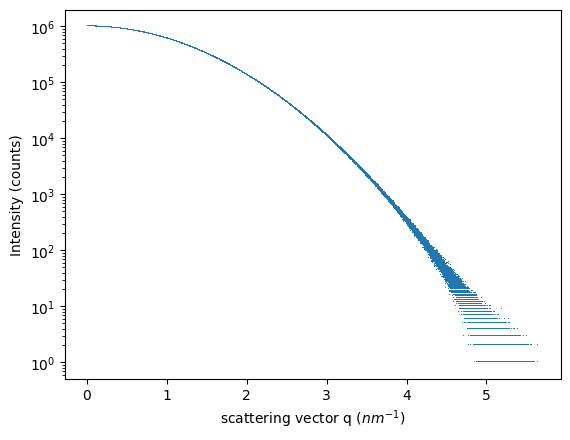

In [5]:
#Guinier-like scatterer
I = 1e6*numpy.exp(-q**2/2)
#Add some noise to make it look real
Y = numpy.random.poisson(I)
fig, ax = subplots()
ax.semilogy(q.ravel(), Y.ravel(), ",")
ax.set_ylabel("Intensity (counts)")
ax.set_xlabel("scattering vector q ($nm^{-1}$)")
pass

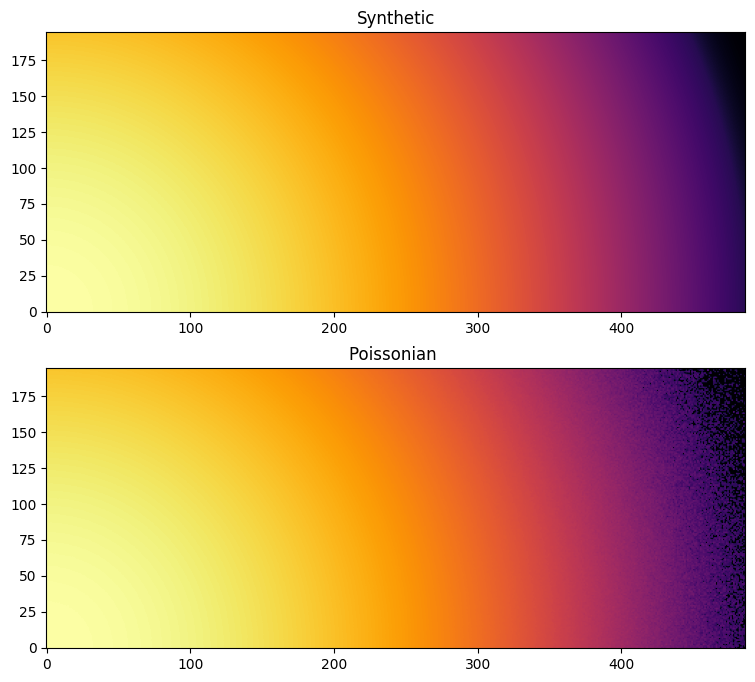

In [6]:
fig, ax = subplots(2,1, figsize=(15,8))
jupyter.display(I, ax=ax[0], label="Synthetic")
jupyter.display(Y, ax=ax[1], label="Poissonian ")
pass

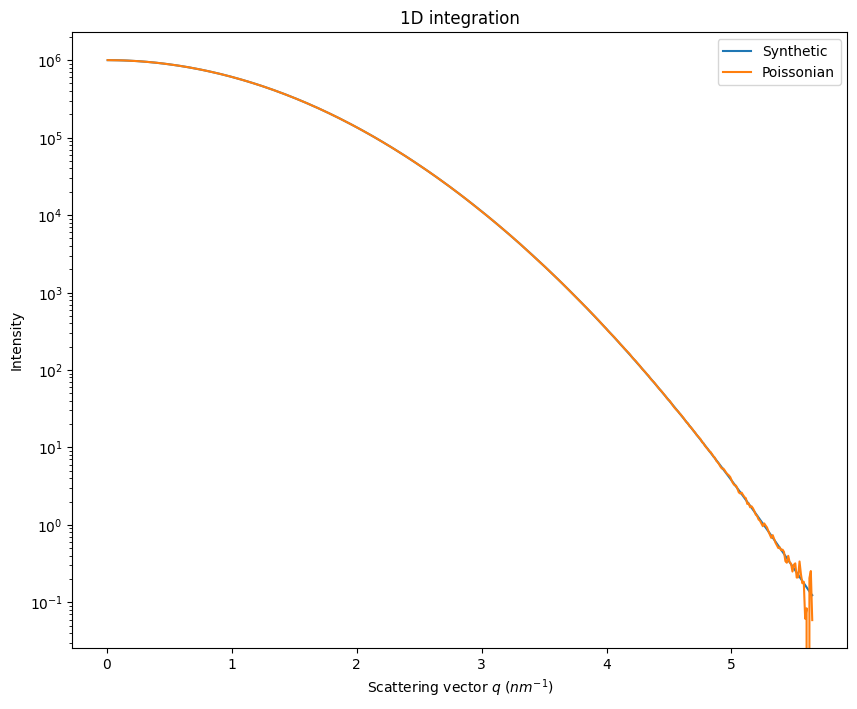

In [7]:
fig, ax = subplots(figsize=(10,8))
jupyter.plot1d(ai.integrate1d(I, 500), ax=ax, label="Synthetic")
ax.plot(*ai.integrate1d(Y, 500), label="Poissonian")
ax.legend()
ax.semilogy()
pass

## Selection of the log-space rebinning

In this section we see how to switch to log-scale at the integration level (and revert back to q_nm^-1 for plotting).

PyFAI does not like negative radial units. Hence log(q) has to be prohibited. I would recommend the $arcsinh$ functions which is a well behaved function from R -> R with a slope at the origin of 1 and a log-scale behaviour.

/tmp/ipykernel_3747071/1556268601.py:4: RuntimeWarning: invalid value encountered in log1p
  ax.plot(x, numpy.log1p(x), label="log(1+x)")


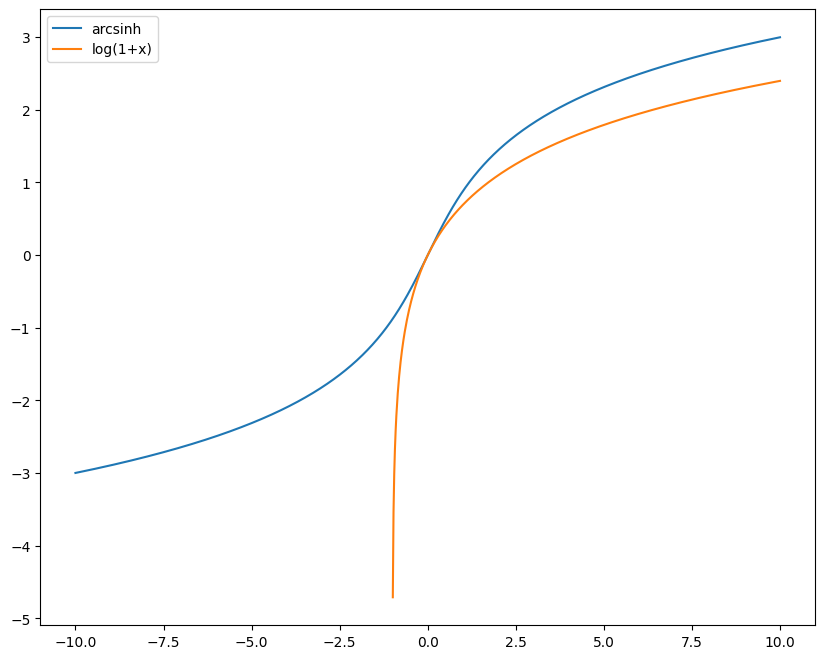

In [8]:
x = numpy.linspace(-10, 10, 1000)
fig, ax = subplots(figsize=(10,8))
ax.plot(x, numpy.arcsinh(x), label="arcsinh")
ax.plot(x, numpy.log1p(x), label="log(1+x)")
ax.legend()
pass

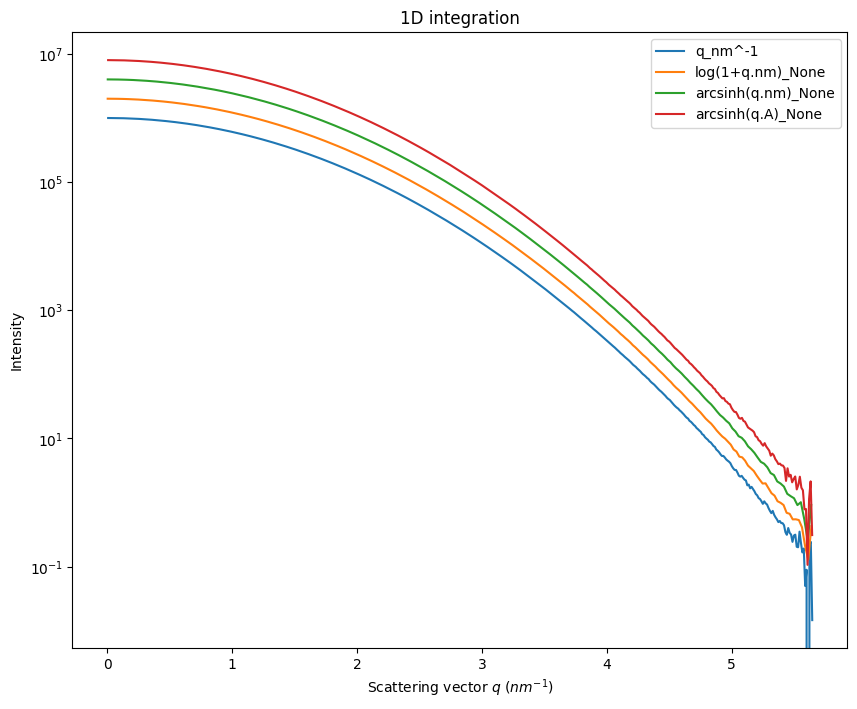

In [9]:
fig, ax = subplots(figsize=(10,8))
jupyter.plot1d(ai.integrate1d(Y, 500, method=method),ax=ax, label="q_nm^-1")
ax.semilogy()
x,y = ai.integrate1d(Y, 500, unit="log(1+q.nm)_None", method=method)
ax.plot(numpy.exp(x)-1,y*2, label="log(1+q.nm)_None")
x,y = ai.integrate1d(Y, 500, unit="arcsinh(q.nm)_None", method=method)
ax.plot(numpy.sinh(x), y*4, label="arcsinh(q.nm)_None")
x,y = ai.integrate1d(Y, 500, unit="arcsinh(q.A)_None", method=method)
ax.plot(numpy.sinh(x)*10, y*8, label="arcsinh(q.A)_None")
ax.legend()
pass

Going to log-scale helps to reduce the noise at high $q$ as on can see in the log(1+q.nm) or arcsinh(q.nm). 
The maximum value for $q$ is only 0.56${A}$, so after taking the log scale this remain in the linear part of the curve.
On the opposite, one would like to histogram on bins with larger numerical values. This is what we will see now. 

## Creation of a new radial unit

Let's create the $arcsinh(q.µm)$ unit. 
$q$ in inverse micrometer has numerical values 1000 times larger than in inverse nanometer, and should emphathize the curvature.

There are two way to define a new unit:
* with a python function implementing the formula, using numpy 
* with a mathematical formula as a string, using numexpr (which provides parallel execution for array initialization)

In [10]:
from pyFAI.units import eq_q, formula_q, register_radial_unit

register_radial_unit("arcsinh(q.µm)_Numpy",
                     scale=1.0,
                     label=r"arcsinh($q$.µm)",
                     equation=lambda x, y, z, wavelength: numpy.arcsinh(1000*eq_q(x, y, z, wavelength)))


print("A function implementing the formula:\n",inspect.getsource(eq_q))
      
print(f"Mathematical formula: {formula_q}")


A function implementing the formula:
 def eq_q(x, y, z, wavelength):
    """Calculates the modulus of the scattering vector

    :param x: horizontal position, towards the center of the ring, from sample position
    :param y: vertical position, to the roof, from sample position
    :param z: distance from sample along the beam
    :param wavelength: in meter
    :return: modulus of the scattering verctor q in inverse nm
    """
    return 4.0e-9 * numpy.pi * numpy.sin(eq_2th(x, y, z) / 2.0) / wavelength

Mathematical formula: 4.0e-9*π/λ*sin(0.5*arctan2(sqrt(x * x + y * y), z))


In [11]:
# Litteral formula can also be provided:

register_radial_unit("arcsinh(q.µm)_Numexpr",
                     scale=1.0,
                     label=r"arcsinh($q$.µm)",
                     formula="arcsinh(4.0e-6*π/λ*sin(arctan2(sqrt(x**2 + y**2), z)/2.0))")

# This uses numexpr which is multithreaded

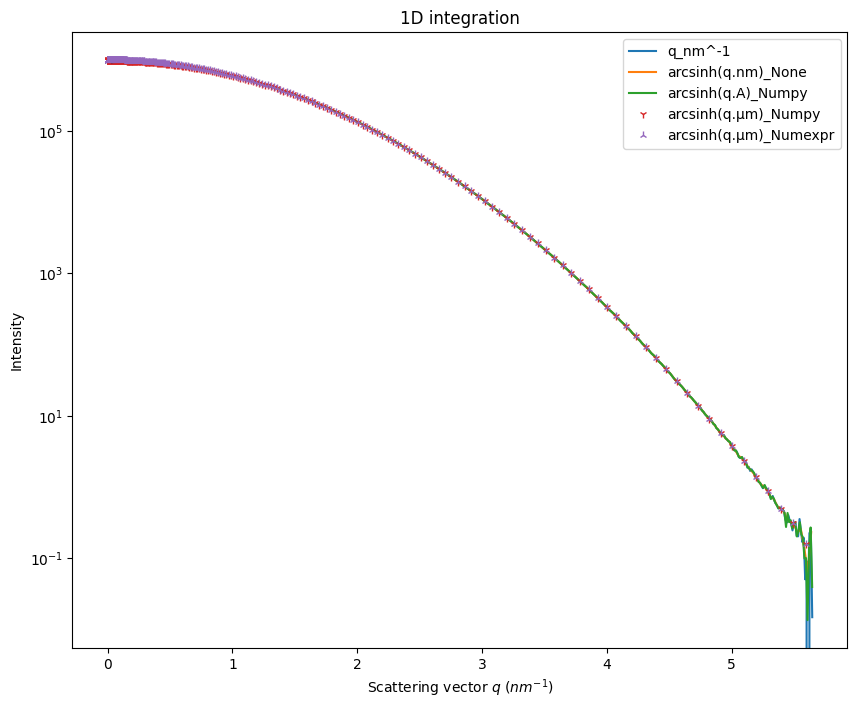

In [12]:
fig, ax = subplots(figsize=(10,8))
jupyter.plot1d(ai.integrate1d(Y, 500, method=method),ax=ax, label="q_nm^-1")
ax.semilogy()
x,y = ai.integrate1d(Y, 500, unit="arcsinh(q.nm)_None", method=method)
ax.plot(numpy.sinh(x), y, label="arcsinh(q.nm)_None")
x,y = ai.integrate1d(Y, 500, unit="arcsinh(q.A)_None", method=method)
ax.plot(numpy.sinh(x)*10, y, label="arcsinh(q.A)_Numpy")
x,y = ai.integrate1d(Y, 500, unit="arcsinh(q.µm)_Numpy", method=method)
ax.plot(numpy.sinh(x)/1000, y, "1", label="arcsinh(q.µm)_Numpy")
x,y = ai.integrate1d(Y, 500, unit="arcsinh(q.µm)_Numexpr", method=method)
ax.plot(numpy.sinh(x)/1000, y, "2", label="arcsinh(q.µm)_Numexpr")

ax.legend()
pass

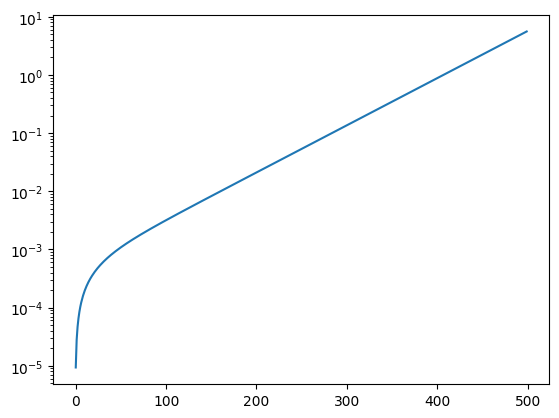

In [13]:
fig, ax = subplots()
ax.plot(numpy.sinh(x)/1000)
ax.semilogy()
pass

*Nota:* Expressing q in $µm^{-1}$ heavily distorts the curve in the low $q$ region, causing an oversampling near $q=0$. A factor 10 to 100 would have been better than the 1000 used in this example.

## Conclusion

We have seen how to perform azimuthal integration with variable bin-size in pyFAI, especially in the context of SAXS where it is desirable to have larger bins at large $q$ values to reduce the noise in this region.

In [14]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f} s")

Total execution time: 3.985 s
